# 필요 라이브러리 설치 및 불러오기

In [ ]:
!pip install pandas
!pip install osmnx
!pip install networkx
!pip install haversine
!pip install selenium
!pip install folium
!pip install geopy
!pip install requests
!pip install time
!pip install random
!pip install math
!pip install json
!pip install os
!pip install urllib

In [5]:
import pandas as pd
import osmnx as ox
import networkx as nx
from haversine import haversine
from selenium import webdriver
import folium
import json
import os
import urllib.request
import time
import requests
import osmnx as ox, networkx as nx
from geopy.distance import great_circle
import random
import math

# score 데이터 불러오기

In [6]:
df_node_score = pd.read_csv('자연_score_final.csv')

# 자동 경로 추천
## A) 출발지 입력

In [22]:
start_lo = input("출발지를 입력하세요 : ")  #start_location
want_dist = int(input('원하는 거리를 입력하세요 : '))
#네이버 지도 크롤링을 통해 도로명 주소 가져오기
br = webdriver.Chrome('./chromedriver')
br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(start_lo))
s_id = br.find_element_by_css_selector('a.item_address._btnAddress')
start_juso = s_id.text[5:]

#네이버 api - Geocoding사용 -> 원하는 위치의 도로명주소 입력시 위도/경도 반환
def search_map(search_text):
    mytext = urllib.parse.quote(search_text)
    url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+mytext
    client_id = 'xheavx7ntb'
    client_secret = 'otYcVEJgDKbT7Hj9VTyDGGD58G7YUQdn258ZPYd5'
    request = urllib.request.Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
    request.add_header('X-NCP-APIGW-API-KEY', client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode == 200):
        response_body = response.read()
        return response_body.decode('utf-8')
    else:
        print("error code : " + rescode)


s_lo = search_map(start_juso)
s_lo = json.loads(s_lo)
s_lo = s_lo['addresses'][0]
#print(user)
s_lat = float(s_lo['y'])      #start_latitude
s_lon = float(s_lo['x'])
print("출발지 위도는 {} 경도는 {} 입니다.".format(s_lat, s_lon))

br.close()

if want_dist > 7: num = 1.5
else: num = 1

출발지를 입력하세요 :  동국대학교
원하는 거리를 입력하세요 :  5


출발지 위도는 37.5582582 경도는 127.0001869 입니다.


## B) 좌표 주위 데이터 필터링

In [23]:
class Mapping:
    def __init__(self, df, lat, lon, dist=1):
        self.df = df
        self.lat = lat
        self.lon = lon
        self.dist = dist
        
    """
    위도 사이의 거리에 0.01을 곱하면 약 1km,
    경도의 경우 0.015를 곱하면 약 1km
    """
    # 사각형 범위 내 조건에 맞는 데이터 갯수 추출
    def filter_by_rectangle(self):
        lat_min = self.lat - 0.01 * self.dist
        lat_max = self.lat + 0.01 * self.dist

        lon_min = self.lon - 0.015 * self.dist
        lon_max = self.lon + 0.015 * self.dist

        self.points = [[lat_min, lon_min], [lat_max, lon_max]]

        result = self.df.loc[
            (self.df['lat'] > lat_min) &
            (self.df['lat'] < lat_max) &
            (self.df['lon'] > lon_min) &
            (self.df['lon'] < lon_max)
        ]
        result.index = range(len(result))

        return result
    
    def filter_by_radius(self):
        # 사각 범위 내 데이터 필터링
        tmp = self.filter_by_rectangle()

        # 기준 좌표 포인트
        center = (self.lat, self.lon)

        result = pd.DataFrame()
        for index, row in tmp.iterrows():
            # 개별 좌표 포인트
            point = (row['lat'], row['lon'])
            d = great_circle(center, point).kilometers
            if d <= self.dist:
                result = pd.concat([result, tmp.iloc[index, :].to_frame().T])

        result.index = range(len(result))
        
        return result        
        
    def show_rectangle(self, df):
        m = folium.Map(location=[self.lat, self.lon], zoom_start=14)
        #서울시 격자 파일
        with open('10_seoul_municipalities_geo.json',mode='rt',encoding='utf-8') as f: 
            geo = json.loads(f.read())
            f.close()

        folium.GeoJson(
            geo,
            name='seoul_municipalities').add_to(m)

        
        for idx, row in df.iterrows():
            lat_ = row['lat']
            lon_ = row['lon']
            
            folium.Circle(location=[lat_, lon_],
                        radius=1,
                        tooltip=row[0]).add_to(m)
        # 출발 좌표       
        folium.Marker(location=[s_lat,s_lon],
                     icon=folium.Icon(color='red', icon='Star'),popup='기준점').add_to(m)
        # 검출된 범위 시각화
        folium.Rectangle(bounds=self.points,
                         color='#ff7800',
                         fill=True,
                         fill_color='#ffff00',
                         fill_opacity=0.2).add_to(m)

        return m

In [24]:
final_map = Mapping(df_node_score,s_lat, s_lon, dist = num)

# 반경 범위 내 데이터 검출
result = final_map.filter_by_radius()

print('중심 좌표:', final_map.lat, final_map.lon)
print('기준 거리:', final_map.dist,'km')
print('기존 데이터셋 크기:' ,len(df_node_score))
print('반경 범위 내 데이터 필터링 결과:',len(result),'건')

중심 좌표: 37.5582582 127.0001869
기준 거리: 1 km
기존 데이터셋 크기: 5539
반경 범위 내 데이터 필터링 결과: 481 건


In [25]:
final_map.show_rectangle(result) # html 파일로 확인

## C) 유전 알고리즘을 위한 코드

In [26]:
# score 상위 50% 데이터 중 좌표 9개 랜덤추출 + 시작점 좌표 1개 = 10개 좌표를 반환하는 함수
def random_select_node(df):
    final_df = df.sort_values(by=['score'], axis=0, ascending=False)
    num = int(len(df)/2)
    final = final_df[:num].sample(n=9)
    final.loc[0] = [9999.0, s_lat, s_lon] # 시작점
    return final


# 추천 좌표와 제일 가까운 노드를 반환하는 함수
def find_nearest_node(df):
    lst = []

    for node in df:
        tmp = ox.distance.nearest_nodes(G, node[1], node[0])
        lst.append(tmp)

    return lst



# 추천 경로의 총 거리를 반환하는 함수
def running_route_distance(lst):
    route_dist = 0.0
    num = len(lst)

    for i in range(0,num):

        if i<(num-1):
            orig_node = int(lst[i])
            dest_node = int(lst[i+1])
        else:
            orig_node = int(lst[i])
            dest_node = int(lst[0])

        length = nx.shortest_path_length(G, orig_node, dest_node, weight='length')/1000
        route_dist += length

    return round(route_dist,2)



# 추천 경로를 반환하는 함수
def make_running_route(node_lst):
    routes = []
    for i in range(0,10):
        if i < 9:
            route = ox.distance.shortest_path(G, node_lst[i], node_lst[i+1], weight='length') # 순서대로 코스 연결
        else:
               route = ox.distance.shortest_path(G, node_lst[i], node_lst[0], weight='length') # 코스 마지막과 첫번째 시작점 연결
        routes.append(route)
    return routes


def show_running_route_folium(routes, dist):
    m = folium.Map(location=[s_lat, s_lon], zoom_start=7)

    print('코스의 길이 :', dist, 'km')    

    for route in routes:
        ox.folium.plot_route_folium(G, route, route_map=m)

    folium.Marker(location=[s_lat, s_lon],
                 icon=folium.Icon(color='red'), popup=start_lo).add_to(m)
    return m


def show_running_route(routes, dist):
    m = folium.Map(location=[s_lat, s_lon], zoom_start=7)

    print('코스의 길이 :', dist, 'km')    

    return ox.plot.plot_graph_routes(G, routes, figsize=(40,40), node_size=0, edge_linewidth=2, route_linewidths=7)

In [27]:
G = ox.graph_from_place(['중구, 서울, 대한민국','용산구, 서울, 대한민국','성동구, 서울, 대한민국'], network_type='walk', simplify=False)
ox.config(use_cache=True, log_console=True)

## D) 유전 알고리즘_원형코스추천

In [28]:
while True:    # 각 좌표의 위치를 표시하는 클래스
    class Point:
        def __init__(self, x=None, y=None):
            self.x = None
            self.y = None
            if x is not None:
                self.x = x
            else:
                self.x = int(random.random() * 200)
            if y is not None:
                self.y = y
            else:
                self.y = int(random.random() * 200)

        def getX(self):
            return self.x

        def getY(self):
            return self.y

        def distanceTo(self, city):
            xDistance = abs(self.getX() - city.getX())
            yDistance = abs(self.getY() - city.getY())
            distance = math.sqrt( (xDistance*xDistance) + (yDistance*yDistance) )
            return distance

        def __str__(self):
            return str(self.getX()) + ", " + str(self.getY())


    # 모든 지점의 정보를 저장하는 클래스
    class Point_info:
        destinationPoints = []

        def addPoint(self, point):
            self.destinationPoints.append(point)

        def getPoint(self, index):
            return self.destinationPoints[index]

        def numberOfPoints(self):
            return len(self.destinationPoints)


    class Route:
        def __init__(self, point_info, route=None):
            self.point_info = point_info
            self.route = []
            self.fitness = 0.0
            self.distance = 0
            if route is not None:
                self.route = route
            else:
                for i in range(0, self.point_info.numberOfPoints()):
                    self.route.append(None)

        def __len__(self):
            return len(self.route)

        def __getitem__(self, index):
            return self.route[index]

        def __setitem__(self, key, value):
            self.route[key] = value

        def __str__(self):
            String = '출발 \n'
            String += '-'*50 + '\n'
            for i in range(0, self.routeSize()):
                String += str(i+1) +'번째)' + str(self.getPoint(i)) +'\n'
            String += '도착'
            String += '-'*50 + '\n'
            return String

        # route 리스트를 무작위로 섞어서 생성하기
        def generateIndividual(self):
            for i in range(0, self.point_info.numberOfPoints()):
                self.setPoint(i, self.point_info.getPoint(i))
            random.shuffle(self.route)

        def getPoint(self, routePosition):
            return self.route[routePosition]

        # 초기화
        def setPoint(self, routePosition, point):
            self.route[routePosition] = point
            self.fitness = 0.0
            self.distance = 0

        # 점수를 거리의 역수로 계산 == 점수(fitness)와 거리(distance)는 반비례.
        # 거리가 짧을 수록 점수가 높음
        def getFitness(self):
            if self.fitness == 0:
                self.fitness = 1/float(self.getDistance())
            return self.fitness

        # route의 총 거리를 계산하는 메소드
        # 전체 경로의 길이 반환, 마지막 인덱스의 지점은 0번째 지점과 거리 계산
        def getDistance(self):
            if self.distance == 0:
                totalDistance = 0
                for i in range(0, self.routeSize()):
                    start = self.getPoint(i)
                    if i+1 < self.routeSize():
                        end = self.getPoint(i+1)
                    else:
                        end = self.getPoint(0)
                    totalDistance += start.distanceTo(end)
                self.distance = totalDistance
            return self.distance

        def routeSize(self):
            return len(self.route)

        def containsPoint(self, point):
            return point in self.route


    # 경로의 집합을 의미하는 클래스 (한 세대에 존재하는 모든 경로를 저장함)
    # 여러가지 route를 구성하고 fitness와 distance를 계산하여
    # fitness가 높은 것을 mutate(변이)하고 crossover(진화)하여 더 좋은 값을 가지는 population을 생성
    class Population:
        def __init__(self, point_info, populationSize, initialize):
            self.routes = []
            for i in range(0, populationSize):
                self.routes.append(None)

            if initialize:
                for i in range(0, populationSize):
                    newRoute = Route(point_info)
                    newRoute.generateIndividual()
                    self.saveRoute(i, newRoute)

        def __setitem__(self, key, value):
            self.routes[key] = value

        def __getitem__(self, index):
            return self.routes[index]

        def saveRoute(self, index, route):
            self.routes[index] = route

        def getRoute(self, index):
            return self.routes[index]

        # 최적 값을 갖는 경로를 리턴
        def getFittest(self):
            fittest = self.routes[0]
            for i in range(0, self.populationSize()):
                if fittest.getFitness() <= self.getRoute(i).getFitness():
                    fittest = self.getRoute(i)
            return fittest

        def populationSize(self):
            return len(self.routes)


    # 유전알고리즘 클래스
    class GA:
        def __init__(self, point_info):
            self.point_info = point_info
            self.mutationRate = 0.05
            self.tournamentSize = 5
            self.elitism = True

        # 진화하는 메소드
        def evolvePopulation(self, pop):
            newPopulation = Population(self.point_info, pop.populationSize(), False)
            if self.elitism:
                newPopulation.saveRoute(0, pop.getFittest()) #0번 인덱스에 최고의 유전자(경로)를 저장

            # 랜덤으로 2개를 추출해 결합
            for i in range(1, newPopulation.populationSize()):
                parent1 = self.tournamentSelection(pop)
                parent2 = self.tournamentSelection(pop)
                child = self.crossover(parent1, parent2)
                newPopulation.saveRoute(i, child)

            # 돌연변이
            for i in range(1, newPopulation.populationSize()):
                self.mutate(newPopulation.getRoute(i))

            return newPopulation

       # 교차하기 = 자식을 만드는 메소드 (새로운 유전자를 만듦)
        def crossover(self, parent1, parent2):

            child = Route(self.point_info) # 공백의 child 경로 생성

            startPos = int(random.random() * parent1.routeSize())
            endPos = int(random.random() * parent1.routeSize())

            # 1) 랜덤으로 child 일부에 parent1의 유전자를 채움
            for i in range(0, child.routeSize()):
                if startPos < endPos and i > startPos and i < endPos:
                    child.setPoint(i, parent1.getPoint(i))
                elif startPos > endPos:
                    if not (i < startPos and i > endPos):
                        child.setPoint(i, parent1.getPoint(i))

            # 2) 1에서 채우지 않은 유전자에 대해 순서대로 parent2의 유전자를 채움
            for i in range(0, parent2.routeSize()):
                if not child.containsPoint(parent2.getPoint(i)):
                    for j in range(0, child.routeSize()):
                        if child.getPoint(j) == None:
                            child.setPoint(j, parent2.getPoint(i))
                            break
            return child

       # 변이 메소드 (서로의 위치를 바꾸는 방식)
        def mutate(self, route):
            for i in range(0, route.routeSize()):
                if random.random() < self.mutationRate:
                    j = int(route.routeSize() * random.random())

                    point1 = route.getPoint(i)
                    point2 = route.getPoint(j)

                    route.setPoint(j, point1)
                    route.setPoint(i, point2)

        def tournamentSelection(self, pop):
            tournament = Population(self.point_info, self.tournamentSize, False)
            for i in range(0, self.tournamentSize):
                randomId = int(random.random() * pop.populationSize())
                tournament.saveRoute(i, pop.getRoute(randomId))
            fittest = tournament.getFittest()
            return fittest





    final = random_select_node(result)

    population_size = 50 # population 크기
    generations = 100 # 진화를 반복할 세대 수

    # 좌표의 정보를 저장할 공간 생성
    pointinfo = Point_info()

    for idx, row in final.iterrows():
        x = row['lon']
        y = row['lat']
        pointinfo.addPoint(Point(x=x, y=y))

    # 랜덤으로 생성된 population
    pop = Population(pointinfo, populationSize=population_size, initialize=True)

    gen = GA(pointinfo)

    # n 세대의 진화를 거침
    for i in range(generations):
            pop = gen.evolvePopulation(pop) # 진화

    recommend_routes = pop.getFittest()
    recommend_lst = []

    for route in recommend_routes:
        lat = route.y
        lon = route.x
        recommend_lst.append([lat,lon])

    node_lst = find_nearest_node(recommend_lst)

    dist = running_route_distance(node_lst)
    
    # 오차 범위 내의 경로가 나올 때 까지 반복
    if (dist > want_dist-(want_dist/30)) & (dist < want_dist+(want_dist/30)):
        print('생성 완료')
        print(pop.getFittest())
        break
    else:
        print('조건에 맞는 경로를 생성 중입니다.')
        pass



조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
조건에 맞는 경로를 생성 중입니다.
생성 완료
출발 
--------------------------------------------------
1번째)126.99680233645006, 37.559665247724936
2번째)126.99697151283202, 37.560346708575246
3번째)126.98994029999788, 37.561080400000506
4번째)126.99042069999999, 37.56205139999999
5번째)126.99661770000002, 37.5639628
6번째)127.0014912, 37.5615415
7번째)127.0053701, 37.55798939999999
8번째)127.0038155, 37.5552407
9번째)127.0026338, 37.553891799999995
10번째)127.0001869, 37.5582582
도착--------------------------------------------------



## 자동 코스 결과

### 1) 중구, 동국대학교, 5km

In [29]:
routes = make_running_route(node_lst)
show_running_route_folium(routes, dist)

코스의 길이 : 5.01 km


코스의 길이 : 5.01 km


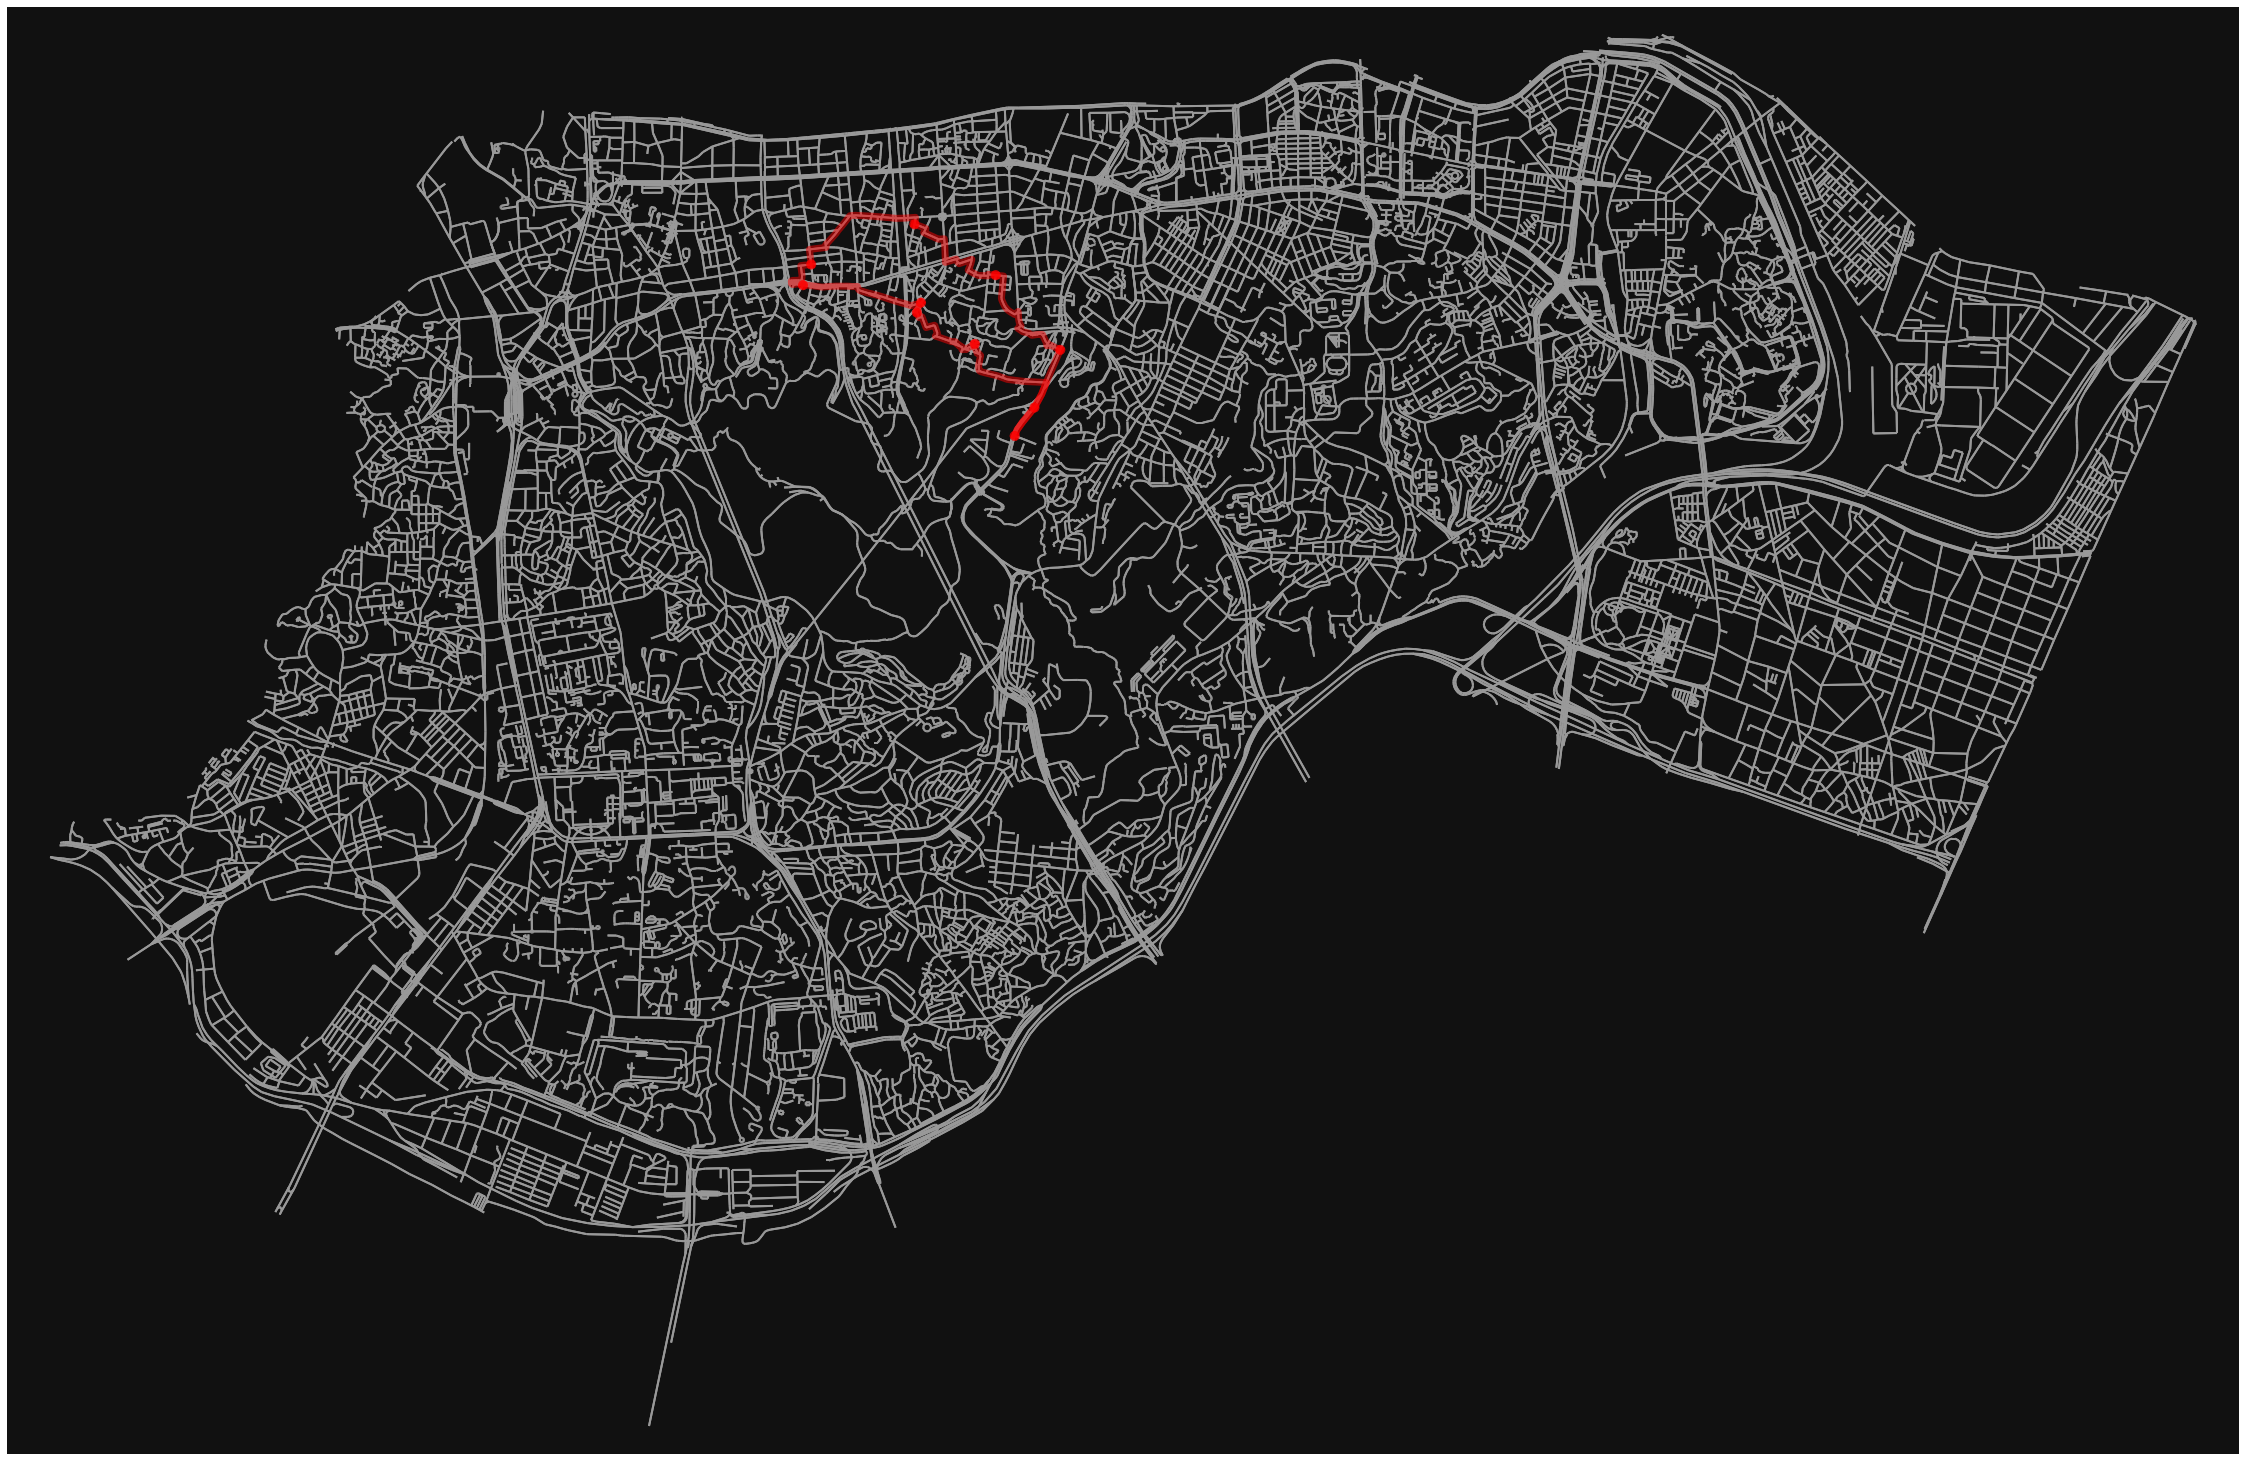

(<Figure size 2880x2880 with 1 Axes>, <AxesSubplot:>)

In [30]:
routes = make_running_route(node_lst)
show_running_route(routes, dist)

# 2. 구간 경로 추천
## A) 출발지, 도착지 입력

In [31]:
start_lo = input("출발지를 입력하세요 : ")
end_lo = input("목적지를 입력하세요 : ")


br = webdriver.Chrome('./chromedriver')
br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(start_lo))
s_id = br.find_element_by_css_selector('a.item_address._btnAddress')
start_juso = s_id.text[5:]

br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(end_lo))
e_id = br.find_element_by_css_selector('a.item_address._btnAddress')
end_juso = e_id.text[5:]   #슬라이싱으로 원하는 도로명 주소만 가져오기

def search_map(search_text):
    mytext = urllib.parse.quote(search_text)
    url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+mytext
    client_id = 'xheavx7ntb'
    client_secret = 'otYcVEJgDKbT7Hj9VTyDGGD58G7YUQdn258ZPYd5'
    request = urllib.request.Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
    request.add_header('X-NCP-APIGW-API-KEY', client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if(rescode == 200):
        response_body = response.read()
        return response_body.decode('utf-8')
    else:
        print("error code : " + rescode)
        
s_lo = search_map(start_juso)
s_lo = json.loads(s_lo)
s_lo = s_lo['addresses'][0]
#print(user)
s_lat = float(s_lo['y'])      #start_latitude
s_lon = float(s_lo['x'])
print("출발지 위도는 {} 경도는 {} 입니다.".format(s_lat, s_lon))

e_lo = search_map(end_juso)
e_lo = json.loads(e_lo)
e_lo = e_lo['addresses'][0]
#print(user)
e_lat = float(e_lo['y'])      #end_latitude
e_lon = float(e_lo['x'])
print("도착지 위도는 {} 경도는 {} 입니다.".format(e_lat, e_lon))

start_list = [s_lat, s_lon]
end_list = [e_lat, e_lon]
print(start_list)
print(end_list)

br.close()

출발지를 입력하세요 :  숙명여대
목적지를 입력하세요 :  한양대


출발지 위도는 37.5459469 경도는 126.9645778 입니다.
도착지 위도는 37.5575753 경도는 127.0466899 입니다.
[37.5459469, 126.9645778]
[37.5575753, 127.0466899]


## B) 좌표 주위 데이터 필터링

In [32]:
class Mapping:

    def __init__(self, df, s_lat, s_lon, e_lat, e_lon):
        self.df = df
        self.s_lat = s_lat
        self.s_lon = s_lon  
        self.e_lat = e_lat
        self.e_lon = e_lon

    # 최소 위도,최대 위도, 최소 경도, 최대 경도를 설정하여 범위 내 데이터를 필터링하는 함수
    def filter_by_rectangle(self):
        
        if (self.s_lat > self.e_lat):
            lat_min = self.e_lat
            lat_max = self.s_lat
        else:
            lat_min = self.s_lat
            lat_max = self.e_lat
        
        if (self.s_lon > self.e_lon):
            lon_min = self.e_lon
            lon_max = self.s_lon
        else:
            lon_min = self.s_lon
            lon_max = self.e_lon
            
        
        self.points = [[lat_min, lon_min], [lat_max, lon_max]]
        
        result = 1
        result = self.df.loc[
            (self.df['lat'] > lat_min) &
            (self.df['lat'] < lat_max) &
            (self.df['lon'] > lon_min) &
            (self.df['lon'] < lon_max)
        ]
        result.index = range(len(result))

        return result
    
    # 범위 내의 데이터를 시각화하는 함수
    def show_rectangle(self, df):
        m = folium.Map(location=[self.s_lat, self.s_lon], zoom_start=14)

        
        for idx, row in df.iterrows():
            lat_ = row['lat']
            lon_ = row['lon']
            
            
            folium.Circle(location=[lat_, lon_], radius=1, color='crimson').add_to(m)
        
                
        folium.Marker(location=[s_lat,s_lon],
                     icon=folium.Icon(color='red', icon='Star'),popup='기준점').add_to(m)
        
        folium.Marker(location=[e_lat,e_lon],
                     icon=folium.Icon(color='red', icon='Star'),popup='기준점').add_to(m)

        folium.Rectangle(bounds=self.points,
                         color='#ff7800',
                         fill=True,
                         fill_color='#ffff00',
                         fill_opacity=0.2).add_to(m)
        
        return m

final_map = Mapping(df_node_score,s_lat, s_lon, e_lat, e_lon)
result = final_map.filter_by_rectangle()

print('기존 데이터셋 크기:' ,len(df_node_score))
print('좌표 범위 내 데이터 필터링 결과 :',len(result),'건')

기존 데이터셋 크기: 5539
좌표 범위 내 데이터 필터링 결과 : 1115 건


In [33]:
final_map.show_rectangle(result)

## c) 유전 알고리즘을 위한 함수 모음

In [34]:
# score 상위 50% 데이터 중 좌표 9개 랜덤추출 + 시작점 좌표 1개 = 10개 좌표를 반환하는 함수
def random_select_node(df):
    final_df = df.sort_values(by=['score'], axis=0, ascending=False)
    num = int(len(df)/2)
    final = final_df[:num].sample(n=6)
    return final


# 추천 좌표와 제일 가까운 노드를 반환하는 함수
def find_nearest_node(df):
    lst = []

    for node in df:
        tmp = ox.distance.nearest_nodes(G, node[1], node[0])
        lst.append(tmp)

    return lst



# 추천 경로와 출발점, 도착점을 잇는 함수
def setting_route(lst):
    start = lst[0]
    s_ = [s_lat, s_lon]
    e_ = [e_lat, e_lon]
    
    distance1 = haversine(s_, start, unit='km')
    distance2 = haversine(e_, start, unit='km')
    
    if distance1 < distance2:
        lst.insert(0,s_)
        lst.extend([e_])
    else:
        lst.insert(0,e_)
        lst.extend([s_])
    return lst



# 추천 경로의 총 거리를 반환하는 함수
def running_route_distance(lst):
    route_dist = 0.0
    num = len(lst)

    for i in range(0,num-1):
        orig_node = int(lst[i])
        dest_node = int(lst[i+1])

        length = nx.shortest_path_length(G, orig_node, dest_node, weight='length')/1000
        route_dist += length

    return round(route_dist,2)


# 추천 경로를 반환하는 함수
def make_running_route(node_lst):
    routes = []
    num = len(node_lst)
    for i in range(0,num-1):
        route = ox.distance.shortest_path(G, node_lst[i], node_lst[i+1], weight='length') # 순서대로 코스 연결
        routes.append(route)
    return routes



def show_running_route_folium(routes, dist):
    m = folium.Map(location=[s_lat, s_lon], zoom_start=6)

    print('코스의 길이 :', dist, 'km')    

    for route in routes:
        ox.folium.plot_route_folium(G, route, route_map=m)

    folium.Marker(location=[s_lat, s_lon],
                 icon=folium.Icon(color='red'), popup=start_lo).add_to(m)
    
    folium.Marker(location=[e_lat, e_lon],
                 icon=folium.Icon(color='blue'), popup=end_lo).add_to(m)
    return m


def show_running_route(routes, dist):
    m = folium.Map(location=[s_lat, s_lon], zoom_start=7)

    print('코스의 길이 :', dist, 'km')    

    return ox.plot.plot_graph_routes(G, routes, figsize=(40,40), node_size=0, edge_linewidth=2, route_linewidths=7)

## D) 유전 알고리즘_구간 코스

In [35]:
# 각 좌표의 위치를 표시하는 클래스
class Point:
    def __init__(self, x=None, y=None):
        self.x = None
        self.y = None
        if x is not None:
            self.x = x
        else:
            self.x = int(random.random() * 200)
        if y is not None:
            self.y = y
        else:
            self.y = int(random.random() * 200)
   
    def getX(self):
        return self.x

    def getY(self):
        return self.y

    def distanceTo(self, city):
        xDistance = abs(self.getX() - city.getX())
        yDistance = abs(self.getY() - city.getY())
        distance = math.sqrt( (xDistance*xDistance) + (yDistance*yDistance) )
        return distance
    
    def __str__(self):
        return str(self.getX()) + ", " + str(self.getY())
    
    
# 모든 지점의 정보를 저장하는 클래스
class Point_info:
    destinationPoints = []

    def addPoint(self, point):
        self.destinationPoints.append(point)

    def getPoint(self, index):
        return self.destinationPoints[index]

    def numberOfPoints(self):
        return len(self.destinationPoints)

    
class Route:
    def __init__(self, point_info, route=None):
        self.point_info = point_info
        self.route = []
        self.fitness = 0.0
        self.distance = 0
        if route is not None:
            self.route = route
        else:
            for i in range(0, self.point_info.numberOfPoints()):
                self.route.append(None)

    def __len__(self):
        return len(self.route)

    def __getitem__(self, index):
        return self.route[index]

    def __setitem__(self, key, value):
        self.route[key] = value

    def __str__(self):
        String = '출발 \n'
        String += '-'*50 + '\n'
        for i in range(0, self.routeSize()):
            String += str(i+1) +'번째)' + str(self.getPoint(i)) +'\n'
        String += '도착'
        String += '-'*50 + '\n'
        return String
    
    # route 리스트를 무작위로 섞어서 생성하기
    def generateIndividual(self):
        for i in range(0, self.point_info.numberOfPoints()):
            self.setPoint(i, self.point_info.getPoint(i))
        random.shuffle(self.route)

    def getPoint(self, routePosition='last'):
        if routePosition != 'last':
            return self.route[routePosition]
        else:
            return self.route[-1]

    # 초기화
    def setPoint(self, routePosition, point):
        self.route[routePosition] = point
        self.fitness = 0.0
        self.distance = 0
    
    # 점수를 거리의 역수로 계산 == 점수(fitness)와 거리(distance)는 반비례.
    # 거리가 짧을 수록 점수가 높음
    def getFitness(self):
        if self.fitness == 0:
            self.fitness = 1/float(self.getDistance())
        return self.fitness
    
    # route의 총 거리를 계산하는 메소드
    # 전체 경로의 길이 반환, 마지막 인덱스의 지점은 0번째 지점과 거리 계산
    def getDistance(self):
        if self.distance == 0:
            totalDistance = 0
            for i in range(0, self.routeSize()):
                start = self.getPoint(i)
                if i+1 < self.routeSize():
                    end = self.getPoint(i+1)
                else:
                    end = self.getPoint('last')
                totalDistance += start.distanceTo(end)
            self.distance = totalDistance
        return self.distance

    def routeSize(self):
        return len(self.route)

    def containsPoint(self, point):
        return point in self.route


# 경로의 집합을 의미하는 클래스 (한 세대에 존재하는 모든 경로를 저장함)
# 여러가지 route를 구성하고 fitness와 distance를 계산하여
# fitness가 높은 것을 mutate(변이)하고 crossover(진화)하여 더 좋은 값을 가지는 population을 생성
class Population:
    def __init__(self, point_info, populationSize, initialize):
        self.routes = []
        for i in range(0, populationSize):
            self.routes.append(None)
        
        if initialize:
            for i in range(0, populationSize):
                newRoute = Route(point_info)
                newRoute.generateIndividual()
                self.saveRoute(i, newRoute)
        
    def __setitem__(self, key, value):
        self.routes[key] = value

    def __getitem__(self, index):
        return self.routes[index]

    def saveRoute(self, index, route):
        self.routes[index] = route

    def getRoute(self, index):
        return self.routes[index]
    
    # 최적 값을 갖는 경로를 리턴
    def getFittest(self):
        fittest = self.routes[0]
        for i in range(0, self.populationSize()):
            if fittest.getFitness() <= self.getRoute(i).getFitness():
                fittest = self.getRoute(i)
        return fittest

    def populationSize(self):
        return len(self.routes)


# 유전알고리즘 클래스
class GA:
    def __init__(self, point_info):
        self.point_info = point_info
        self.mutationRate = 0.05
        self.tournamentSize = 5
        self.elitism = True
    
    # 진화하는 메소드
    def evolvePopulation(self, pop):
        newPopulation = Population(self.point_info, pop.populationSize(), False)
        if self.elitism:
            newPopulation.saveRoute(0, pop.getFittest()) #0번 인덱스에 최고의 유전자(경로)를 저장
        
        # 랜덤으로 2개를 추출해 결합
        for i in range(1, newPopulation.populationSize()):
            parent1 = self.tournamentSelection(pop)
            parent2 = self.tournamentSelection(pop)
            child = self.crossover(parent1, parent2)
            newPopulation.saveRoute(i, child)
        
        # 돌연변이
        for i in range(1, newPopulation.populationSize()):
            self.mutate(newPopulation.getRoute(i))
        
        return newPopulation
    
   # 교차하기 = 자식을 만드는 메소드 (새로운 유전자를 만듦)
    def crossover(self, parent1, parent2):
       
        child = Route(self.point_info) # 공백의 child 경로 생성
        
        startPos = int(random.random() * parent1.routeSize())
        endPos = int(random.random() * parent1.routeSize())
        
        # 1) 랜덤으로 child 일부에 parent1의 유전자를 채움
        for i in range(0, child.routeSize()):
            if startPos < endPos and i > startPos and i < endPos:
                child.setPoint(i, parent1.getPoint(i))
            elif startPos > endPos:
                if not (i < startPos and i > endPos):
                    child.setPoint(i, parent1.getPoint(i))
                    
        # 2) 1에서 채우지 않은 유전자에 대해 순서대로 parent2의 유전자를 채움
        for i in range(0, parent2.routeSize()):
            if not child.containsPoint(parent2.getPoint(i)):
                for j in range(0, child.routeSize()):
                    if child.getPoint(j) == None:
                        child.setPoint(j, parent2.getPoint(i))
                        break
        return child
    
   # 변이 메소드 (서로의 위치를 바꾸는 방식)
    def mutate(self, route):
        for i in range(0, route.routeSize()):
            if random.random() < self.mutationRate:
                j = int(route.routeSize() * random.random())
                
                point1 = route.getPoint(i)
                point2 = route.getPoint(j)
                
                route.setPoint(j, point1)
                route.setPoint(i, point2)

    def tournamentSelection(self, pop):
        tournament = Population(self.point_info, self.tournamentSize, False)
        for i in range(0, self.tournamentSize):
            randomId = int(random.random() * pop.populationSize())
            tournament.saveRoute(i, pop.getRoute(randomId))
        fittest = tournament.getFittest()
        return fittest
    


final = random_select_node(result)


population_size = 50 # population 크기
generations = 100 # 진화를 반복할 세대 수

# 좌표의 정보를 저장할 공간 생성
pointinfo = Point_info()

for idx, row in final.iterrows():
    x = row['lon']
    y = row['lat']
    pointinfo.addPoint(Point(x=x, y=y))

# 랜덤으로 생성된 population
pop = Population(pointinfo, populationSize=population_size, initialize=True)

gen = GA(pointinfo)

# n 세대의 진화를 거침
for i in range(generations):
        pop = gen.evolvePopulation(pop) # 진화



print('생성 완료')
print(pop.getFittest())

recommend_routes = pop.getFittest()
recommend_lst = []

for route in recommend_routes:
    lat = route.y
    lon = route.x
    recommend_lst.append([lat,lon])

recommend = setting_route(recommend_lst)

생성 완료
출발 
--------------------------------------------------
1번째)127.02407870000002, 37.55600689999999
2번째)127.0150524, 37.54907680000001
3번째)127.00186809999998, 37.5524406
4번째)126.9686487, 37.55348060000001
5번째)126.96760790000002, 37.55328109999999
6번째)126.9669904, 37.55452509999999
도착--------------------------------------------------



# 구간 지정 코스 결과

## 용산구,숙명여대 - 성동구, 한양대

In [36]:
node_lst = find_nearest_node(recommend)
total_dist = running_route_distance(node_lst)
routes = make_running_route(node_lst)
show_running_route_folium(routes, total_dist)

코스의 길이 : 12.1 km


코스의 길이 : 12.1 km


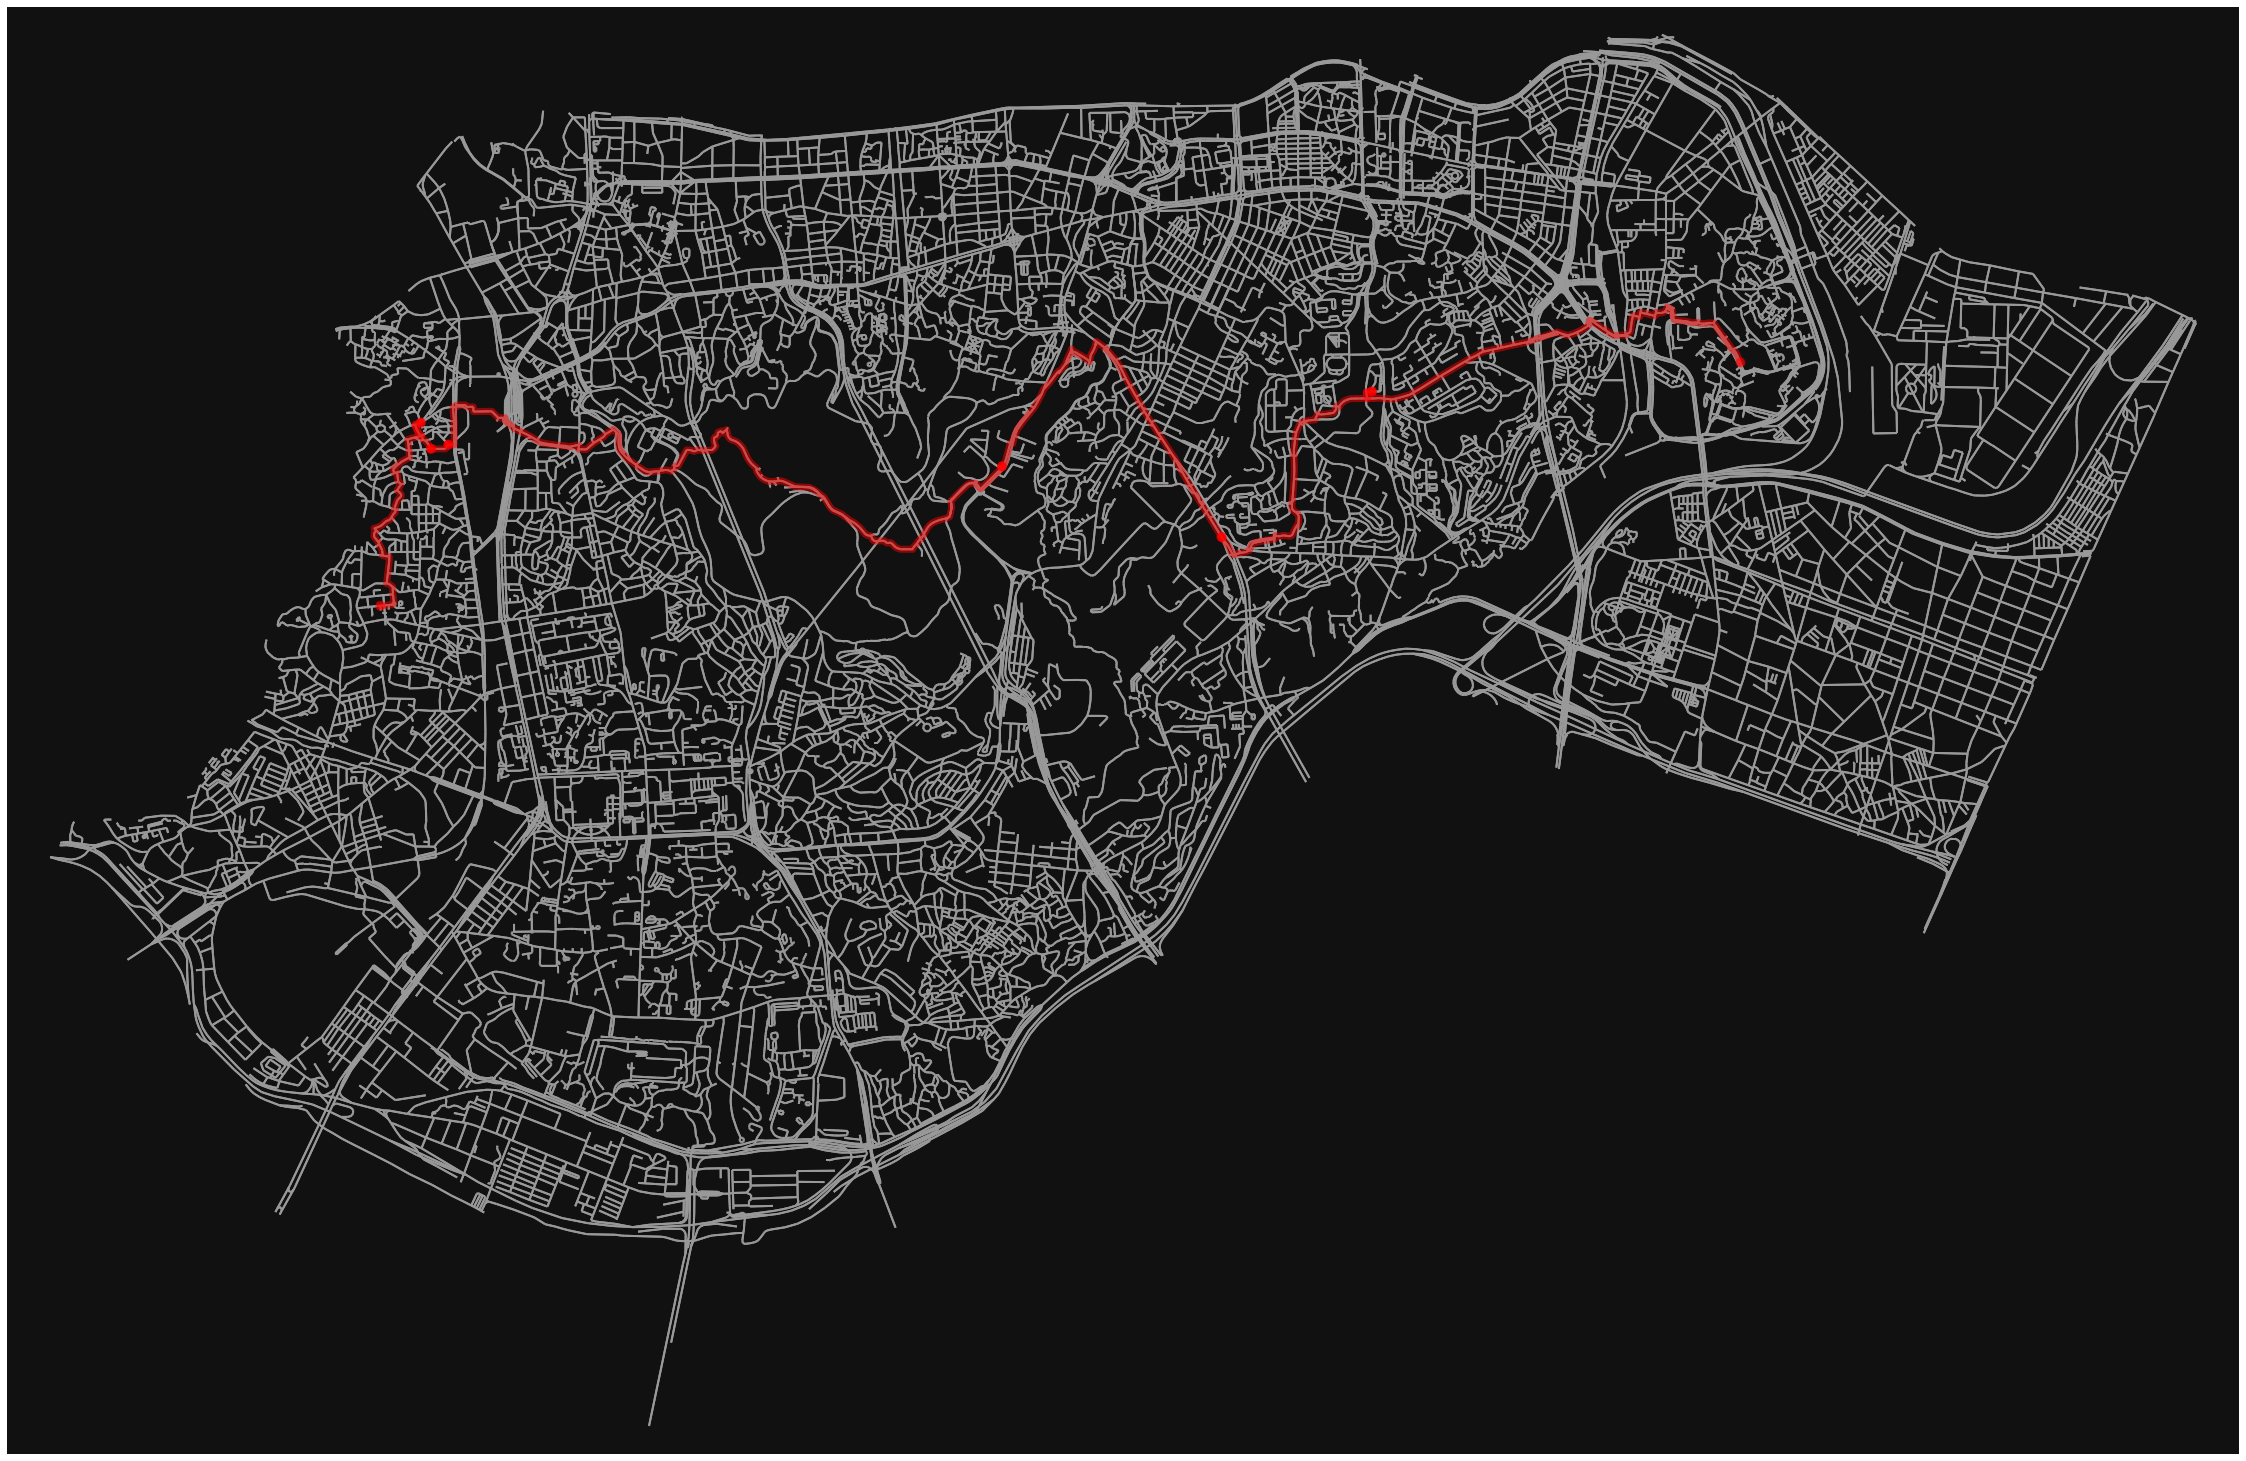

(<Figure size 2880x2880 with 1 Axes>, <AxesSubplot:>)

In [37]:
show_running_route(routes, total_dist)